# <center>Extracting, cleaning, visualizing,<br> and analyzing data from Facebook</center>

During the last decade, social media has become a key element of successful communication campaigns. While there are many factors that determine the success of social media strategies, there is no doubt that data science skills are one of the most important. With that in mind, this tutorial walks the reader through the steps to extract, clean, visualize, and model data from Facebook Pages. 

Given the limited scope of the tutorial, the emphasis is placed on extracting, cleaning, and visualizing data rather than on modeling. However, a toy example of data modeling is presented in order to walk the reader through the complete data science pipeline. The main objectives of the tutorial are the following: 1) show the reader how to generate a dataset ready to be used for modeling and further analysis, and 2) provide business intelligence to optimize Facebook strategies. Since the scope of the tutorial is limited, links to further resources are included throughout the tutorial.

In order to make it easier for the reader, the tutorial works through the example of [Carnegie Mellon University's (CMU) Facebook Page](https://www.facebook.com/carnegiemellonu). The tutorial is divided in four parts:

1. [Data collection](#1.-Data-collection)
2. [Data cleaning](#2.-Data-cleaning)
3. [Data visualization](#3.-Data-visualization)
4. [Data modeling](#4.-Data-modeling) 
5. [Next steps](#5.-Next-steps)

Before jumping into our subject, the following code chunk loads all libraries that will be needed throughout the tutorial. The reader is advised to install and/or load the libraries before continuing.


In [1]:
# Data collection
import json
import urllib
import time
import warnings
warnings.filterwarnings('ignore')
# Data cleaning
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import nltk
import string
import collections
import operator
import sklearn
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 12.0)
# TData modeling
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## 1. Data collection

The [Facebook Graph API](https://developers.facebook.com/docs/graph-api/using-graph-api/) (FB-API) is a powerful and well-documented platform to retrieve data from any Facebook Page. There are multiple operations that can be conducted using the FB-API, such as reading, publishing, updating, or deleting information. Nevertheless, in this tutorial, we are only interested in reading data because we want to retrieve information that can be processed for further analysis. With that in mind, this section shows how to build a URL tailored to the content of interest and how to use that URL to retrieve data from Facebook.

### 1.1 Building the URL

The cornerstone of retrieving data from the FB-API is the URL, which is comprised by the following elements: 

1. The host, which is the same for all requests except videos.
2. The node, which is an object with unique identifier to be queried. In other words, it is the unique Facebook name of the public figure we want to analyze.
3. The edge, which is a collection of objects to a given node.
4. The fields, which are the properties of the node. The reader can change the parameters of the fields to tailor the data that will be retrieved. 
5. The access token, which are the credentials of the user running the application.
6. The limit, which is the number of results returned by the request.


#### 1.1.1 The host
Given that we are not interested in retrieving videos, our host will be fixed.

In [2]:
host = "https://graph.facebook.com"

#### 1.1.2 The node
The node defines the public figure that we want to analyze. In our example, the node is <b><i>CarnegieMellonU</i></b>. 


In [3]:
node = '/CarnegieMellonU'

#### 1.1.3 The edge
There are two public edges that can be used to retrieve information from a Facebook Page: 

1. The <b><i>feed edge</b></i>, which includes posts of three types: posts that  mention  CMU's Facebook Page, 2) posts published by Facebook users in CMU's Facebook Page, 3) and posts published by CMU's Facebook Page itself. 
2. The <b><i>posts edge</b></i>, which is a subset of the feed edge that only shows the posts that were published by CMU.

To narrow the scope down, we will only use the <b><i>posts edge</b></i>. However, the reader is advised to also explore the <b><i>feed edge</b></i>.

In [4]:
edge = "/posts" 

#### 1.1.4 The fields
The fields determine the information that will be retrieved from the request. There is extensive information about additional fields available [here](https://developers.facebook.com/docs/graph-api/reference). Here are the properties that will be extracted in this tutorial: 

- message, which is the text content of the post.
- created_time, which is the datetime returned 8 hours ahead Easter Standard Time (ETS). 
- type, which indicates whether the post is a photo, video, link, status, or music. 
- name, which indicates the name of the post. 
- link, which indicates the link published with the post. 
- status_type, which indicates one of the following categories: added_photos, shared story, added video, or mobile status update.
- shares, which counts the number of times the post was shared. 
- comments, which include the comments associated with the post, as well as the total count of comments for each post.
- reactions, which includes all types of reactions to a post (like, love, sad, haha, wow, angry).

In [5]:
fields = "/?fields=message,created_time,type,name,link,status_type"
fields = fields + ",shares,comments.summary(true),reactions.summary(true)"
fields = fields + ",reactions.type(LIKE).limit(0).summary(1).as(like)"
fields = fields + ",reactions.type(LOVE).limit(0).summary(1).as(love)"
fields = fields + ",reactions.type(HAHA).limit(0).summary(1).as(haha)"
fields = fields + ",reactions.type(WOW).limit(0).summary(1).as(wow)"
fields = fields + ",reactions.type(SAD).limit(0).summary(1).as(sad)"
fields = fields + ",reactions.type(ANGRY).limit(0).summary(1).as(angry)"


#### 1.1.5 The access token
The access token allows users to interact with the FB-API through an application. Since it is confidential, the readers should get their own access token. The steps are the following: 1) register at [Facebook Developer](https://developers.facebook.com), 2) create a new application, 3) get the App ID and the App Secret of the application, and 4) combine them to create the access token using the following code. The access token utilized in this tutorial is disabled after running the code. 

In [6]:
app_id = '830344303820781'
app_secret = '58f5b66496a04d54421f03440db4d3df'
access_token = '&access_token=' + app_id + "|" + app_secret

#### 1.1.6 The limit
Finally, the limit sets the upper limit of posts returned per request. Since the maximum number allowed is 100, we will set it to 100. The default is 25.

In [7]:
limit = '&limit=100'

#### 1.1.7 The URL
Now that we have everything we need, we can simply concatenate the elements to generate a unique URL. 

In [8]:
main_url = host + node + edge + fields + access_token + limit
main_url

'https://graph.facebook.com/CarnegieMellonU/posts/?fields=message,created_time,type,name,link,status_type,shares,comments.summary(true),reactions.summary(true),reactions.type(LIKE).limit(0).summary(1).as(like),reactions.type(LOVE).limit(0).summary(1).as(love),reactions.type(HAHA).limit(0).summary(1).as(haha),reactions.type(WOW).limit(0).summary(1).as(wow),reactions.type(SAD).limit(0).summary(1).as(sad),reactions.type(ANGRY).limit(0).summary(1).as(angry)&access_token=830344303820781|58f5b66496a04d54421f03440db4d3df&limit=100'

### 1.2 Collecting the data

One we have the URL ready, we can start collecting the data. Before we start, the reader should be aware that the FB-API returns [a maximum of 600 ranked posts per year](https://developers.facebook.com/docs/graph-api/reference/v2.12/page/feed). Therefore, as of today (March, 2018), there is no option to retrieve all posts using the FB-API. While there may be ways of doing it with web scrapping, we will only work with the sample returned by the FB-API. As a side note, the author of this tutorial got inspiration from this [repository](https://github.com/minimaxir/facebook-page-post-scraper) while defining the <b><i>FacebookData Class</i></b>.

#### 1.2.1 The FacebookData Class

In [9]:
class FacebookData:
    
    def __init__(self, main_url):
        self.main_url = main_url
    
    
    def clean_post(self, post):
        """DESCRIPTION: extract data of interest from nested dictionaries
                        returned by the request. 
           PARAMETER(S): information of each post in JSON format
           RETURNS: post information as dictionary"""
        
        # Open new dictionary for cleaned data
        d = dict()

        # Clean string variables and get a single cleaned dictionary per variable
        message = {"message": ""} if 'message' not in post.keys() else {"message": post['message']}
        d.update(message)
        status = {"status_type": ""} if 'status_type' not in post.keys() else {"status_type": post['status_type']}
        d.update(status)
        datetime = {"datetime": ""} if 'created_time' not in post.keys() else {"datetime": post['created_time']}
        d.update(datetime)    
        type_post = {"type": ""} if 'type' not in post.keys() else {"type": post['type']}
        d.update(type_post)
        name = {"name": ""} if 'name' not in post.keys() else {"name": post['name']}
        d.update(name)   
        link = {"link": ""} if 'link' not in post.keys() else {"link": post['link']}
        d.update(link)          
        
        # Clean shares and comments and get a single cleaned dictionary per variable
        shares = {"shares": 0} if 'shares' not in post.keys() else {"shares": post['shares']['count']}
        d.update(shares)
        comments = {"comments": 0} if 'comments' not in post.keys() else {"comments": post['comments']['summary']['total_count']}
        d.update(comments)
        
        # Clean reactions. The key 'reactions' is the sum of all types of reactions (like, angry, love, sad, haha, wow)
        reactions = {"reactions": 0} if 'reactions' not in post.keys() else {"reactions": post['reactions']['summary']['total_count']}
        d.update(reactions)         
        like = {"likes": 0} if 'like' not in post.keys() else {"like": post['like']['summary']['total_count']}
        d.update(like)
        angry = {"angry": 0} if 'angry' not in post.keys() else {"angry": post['angry']['summary']['total_count']}
        d.update(angry)
        love = {"love": 0} if 'love' not in post.keys() else {"love": post['love']['summary']['total_count']}
        d.update(love)
        sad = {"sad": 0} if 'sad' not in post.keys() else {"sad": post['sad']['summary']['total_count']}
        d.update(sad)
        haha = {"haha": 0} if 'haha' not in post.keys() else {"haha": post['haha']['summary']['total_count']}
        d.update(haha)   
        wow = {"wow": 0} if 'wow' not in post.keys() else {"wow": post['wow']['summary']['total_count']}
        d.update(wow)
       
        # Return dictionary
        return d


    def get_response_and_next(self, main_url):
        """DESCRIPTION: extract data and next page url from response
           PARAMETER(S): url
           RETURNS: tuple of list of dictionaries and paging dictionary"""

        # Get response in JSON format
        response = json.loads(urllib.request.urlopen(self.main_url).read())

        # Get list of dictionaries with a cleaned dictionary for each post
        data = response['data']
        cleaned_list = []
        for post in data:
            cleaned = self.clean_post(post)
            cleaned_list.append(cleaned) 
        
        # Return tuple with list of dictionaries and paging dictionary
        return (cleaned_list, response['paging'])
    
    
    def get_all_posts(self):
        """DESCRIPTION: extracts all data from a given Facebook Page
           PARAMETER(S): self
           RETURNS: list of dictionaries where each dictionary is a post"""        
        
        # Set a bool to start while loop
        keep_going = True
        
        # Loop over responses until there is no 'next' url
        result = []
        while keep_going is True:
            time.sleep(0.2)
            response = self.get_response_and_next(self.main_url)
            result += response[0]
            if 'next' not in response[1].keys(): break    
            else: self.main_url = response[1]['next']
        
        # Return list of all posts where each post is a dictionary
        return result
    
    
    def get_dataframe(self):
        """DESCRIPTION: converts list of dictionary to dataframe
           PARAMETER(S): self
           RETURNS: dataframe where each row is one post"""         
        list_dictionaries = self.get_all_posts()
        result = pd.DataFrame(list_dictionaries)
        return result
    

#### 1.2.2 The dataframe

Let's combine the URL and the <i><b>FacebookData Class</i></b> to extract all information of interest from CMU's Facebook Page. 

In [10]:
# Extract data from Facebook
posts1 = FacebookData(main_url).get_dataframe()

# Change order of columns
ordered_cols = ['datetime', 'message', 'name', 'status_type', 'type', 'link', 'reactions',
                'like', 'angry','haha', 'love', 'sad', 'wow', 'comments',  'shares']
posts1 = posts1[ordered_cols]

# Print shape and head of dataframe
num_rows = posts1.shape[0]
num_cols = posts1.shape[1]
print("The dataframe has", num_rows, "posts and", num_cols, "attributes")
posts1.head(5)

The dataframe has 3322 posts and 15 attributes


,datetime,message,name,status_type,type,link,reactions,like,angry,haha,love,sad,wow,comments,shares
0,2018-03-28T12:56:05+0000,"Today is Carnegie Mellon's ""Thank a Donor Day!...",Thank a Donor - Engage with CMU - Carnegie Mel...,shared_story,link,https://www.cmu.edu/engage/give/donor-recognit...,40,38,0,0,2,0,0,1,0
1,2018-03-27T15:55:32+0000,"It's officially spring, but CDC officials say ...",Flu Forecasting,added_video,video,https://www.facebook.com/carnegiemellonu/video...,21,21,0,0,0,0,0,0,5
2,2018-03-26T16:25:26+0000,"On Saturday, March 24, Carnegie Mellon Greek S...",Greek Sing 2018,added_photos,photo,https://www.facebook.com/carnegiemellonu/photo...,83,76,0,0,7,0,0,1,3
3,2018-03-22T18:35:02+0000,Are you graduating this May? Today until 7 p.m...,Cap and Gown Information - Commencement Weeken...,shared_story,link,https://www.cmu.edu/commencement/graduates/cap...,51,50,0,0,1,0,0,3,5
4,2018-03-22T14:00:32+0000,The 14th annual Botball competition went down ...,Qatar Academy Wins CMU-Q's Botball - News - Ca...,shared_story,link,https://www.cmu.edu/news/stories/archives/2018...,23,23,0,0,0,0,0,0,1


## 2. Data cleaning

Extracting information from the FB-API provides the raw input to analyze a Facebook Page, but cleaning the data constitutes the grounds for further analysis. This section walks the reader through the steps to clean the data and generate features that can be used for modeling and analysis. The section is divided as follows:

1. Cleaning datetime variables.
2. Generating dummy variables.
3. Processing text. 
4. Creating aggregated dataframes.

For the purposes of this tutorial, we will mostly use <i><b>reactions</i></b> as dependent variable. However, the readers are advised to explore other potential dependent variables such as like, angry, haha, love, sad, wow, shares, and comments. A recommended first step is to run a correlations matrix using the following code.

In [11]:
corr = posts1[['reactions', 'like', 'angry', 'haha',
               'love', 'sad', 'wow', 'shares', 'comments']].corr()
corr

,reactions,like,angry,haha,love,sad,wow,shares,comments
reactions,1.000000,0.998896,0.119820,0.124413,0.778202,0.044226,0.464305,0.633925,0.531314
like,0.998896,1.000000,0.107804,0.113939,0.754479,0.019191,0.439776,0.621094,0.519505
angry,0.119820,0.107804,1.000000,0.057870,0.148707,0.269006,0.145537,0.215937,0.283063
haha,0.124413,0.113939,0.057870,1.000000,0.147860,0.009571,0.075760,0.272177,0.136535
love,0.778202,0.754479,0.148707,0.147860,1.000000,0.033399,0.470385,0.549915,0.488914
sad,0.044226,0.019191,0.269006,0.009571,0.033399,1.000000,0.257398,0.106092,0.126630
wow,0.464305,0.439776,0.145537,0.075760,0.470385,0.257398,1.000000,0.646597,0.500576
shares,0.633925,0.621094,0.215937,0.272177,0.549915,0.106092,0.646597,1.000000,0.633107
comments,0.531314,0.519505,0.283063,0.136535,0.488914,0.126630,0.500576,0.633107,1.000000


### 2.2 The datetime variable

Determining the datetime that maximizes reactions is highly valuable for the community managers in charge of social media campaigns. In this subsection, we generate the following features: time in ETS, year, quarter, month, weekday, hour, elapsed minutes, and sine and cosine transformations for cyclical variables

In [12]:
def clean_datetime(dataframe):
    """DESCRIPTION: generate datetime features from raw dataframe
       PARAMETER(S): dataframe with Facebook posts
       RETURNS: dataframe with datetime features appended"""             
    
    # Copy original dataframe
    clean = dataframe.copy(deep=True)
    
    # Convert datetime to ETS
    clean['datetime'] = pd.to_datetime(clean['datetime']).apply(lambda x: x - timedelta(hours=8))
    
    # Get date variables
    clean['date'] = clean['datetime'].apply(lambda x: x.date())
    clean['weekday_num'] = clean['datetime'].apply(lambda x: x.dayofweek)   
    clean['weekday'] = clean['weekday_num'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
                                                 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
    clean['year'] = clean['datetime'].apply(lambda x: x.year)
    clean['month_num'] = clean['datetime'].apply(lambda x: x.month)
    clean['month'] = clean['month_num'].map({1:'JAN', 2:'FEB', 3:'MAR', 4:'APR',
                                             5:'MAY', 6: 'JUN', 7:'JUL', 8:'AUG',
                                             9: 'SEP', 10:'OCT', 11:'NOV', 12:'DEC'})
    
    clean['day'] = clean['datetime'].apply(lambda x: x.day)
    clean['year_month'] = clean['year'].astype(str) + '-' + clean['month'].astype(str)
    clean['quarter'] = clean['month_num'].map({1:'Q1', 2:'Q1', 3:'Q1',
                                               4:'Q2', 5:'Q2', 6:'Q2',
                                               7:'Q3', 8:'Q3', 9:'Q3',
                                               10:'Q4', 11:'Q4', 12:'Q4'})
    clean['year_quarter'] = clean['year'].astype(str) + '-' + clean['quarter'].astype(str)        
    
    # Get time variables
    clean['time'] = clean['datetime'].apply(lambda x: x.time())
    clean['hour'] = clean['time'].apply(lambda x: x.hour)
    
    
    # Sine and cosine transformations for weekday and hour. This features are useful
    # for data modeling because they capture the cyclical nature of the variables. 
    # Without transformation, 23:00 hrs would be farther away from 2:00 hrs than 11:00 hrs
    two_pi = 2*np.pi  
    clean['sin_weekday'] = clean['weekday_num'].apply(lambda x: np.sin(two_pi*x/7))
    clean['cos_weekday'] = clean['weekday_num'].apply(lambda x: np.cos(two_pi*x/7))
    clean['sin_hour'] = clean['hour'].apply(lambda x: np.sin(two_pi*x/24))
    clean['cos_hour'] = clean['hour'].apply(lambda x: np.cos(two_pi*x/24))    
    
    # Sine and cosine transformation for time of the day
    elap_min_cycle = 60*24
    clean['elap_min'] = clean['time'].apply(lambda x: x.hour*60 + x.minute)     
    clean['sin_elap_min'] = clean['elap_min'].apply(lambda x: np.sin((two_pi*x)/elap_min_cycle))
    clean['cos_elap_min'] = clean['elap_min'].apply(lambda x: np.cos((two_pi*x)/elap_min_cycle))
    
    # Drop duplicated rows based on datetime. The duplication would mean that the
    # post was published exactly at the same date, hour, minute, and second. 
    # Generally, the number of duplicates is considerably small (~5).
    mask = clean.datetime.duplicated(keep=False)
    clean = clean[~mask]
    
    return clean

posts2 = clean_datetime(posts1)
posts2.head()


,datetime,message,name,status_type,type,link,reactions,like,angry,haha,...,year_quarter,time,hour,sin_weekday,cos_weekday,sin_hour,cos_hour,elap_min,sin_elap_min,cos_elap_min
0,2018-03-28 04:56:05,"Today is Carnegie Mellon's ""Thank a Donor Day!...",Thank a Donor - Engage with CMU - Carnegie Mel...,shared_story,link,https://www.cmu.edu/engage/give/donor-recognit...,40,38,0,0,...,2018-Q1,04:56:05,4,0.974928,-0.222521,0.866025,5.000000e-01,296,0.961262,2.756374e-01
1,2018-03-27 07:55:32,"It's officially spring, but CDC officials say ...",Flu Forecasting,added_video,video,https://www.facebook.com/carnegiemellonu/video...,21,21,0,0,...,2018-Q1,07:55:32,7,0.781831,0.623490,0.965926,-2.588190e-01,475,0.876727,-4.809888e-01
2,2018-03-26 08:25:26,"On Saturday, March 24, Carnegie Mellon Greek S...",Greek Sing 2018,added_photos,photo,https://www.facebook.com/carnegiemellonu/photo...,83,76,0,0,...,2018-Q1,08:25:26,8,0.000000,1.000000,0.866025,-5.000000e-01,505,0.806445,-5.913096e-01
3,2018-03-22 10:35:02,Are you graduating this May? Today until 7 p.m...,Cap and Gown Information - Commencement Weeken...,shared_story,link,https://www.cmu.edu/commencement/graduates/cap...,51,50,0,0,...,2018-Q1,10:35:02,10,0.433884,-0.900969,0.500000,-8.660254e-01,635,0.362438,-9.320079e-01
4,2018-03-22 06:00:32,The 14th annual Botball competition went down ...,Qatar Academy Wins CMU-Q's Botball - News - Ca...,shared_story,link,https://www.cmu.edu/news/stories/archives/2018...,23,23,0,0,...,2018-Q1,06:00:32,6,0.433884,-0.900969,1.000000,6.123234e-17,360,1.000000,6.123234e-17


### 2.2 Dummy variables

Dummy variables can be powerful features. In general, the variables <i><b>has_link</b></i> and <i><b>is_weekend</b></i> are useful for most Facebook Pages. However, some dummy variables require domain knowledge that depend on the Facebook Page of interest. For our example, we will create <i><b>is_graduation</b></i>. However, the reader is advised to create appropriate dummy variables for the Facebook Page of interest.


In [13]:
def generate_dummies(dataframe):
    """DESCRIPTION: generates dummies for Facebook dataframe
       PARAMETER(S): dataframe with Facebook posts
       RETURNS: dataframe with dummies appended"""      
    
    # Copy original dataframe
    data = dataframe.copy(deep=True)
    
    # Create indicator for link variable as 1 if post contains link and 0 if not
    data['has_link'] = [1 for i in range(len(data.index))]
    data.loc[data.link == "", 'has_link'] = 0
    
    # Create indicator for weekend variable as 1 if post is publushed during the weekend
    data['is_weekend'] = [0 for i in range(len(data.index))]
    data.loc[data.weekday_num == 5, 'is_weekend'] = 1    
    data.loc[data.weekday_num == 6, 'is_weekend'] = 1        

    # Create dummy for is_graduation if date is between May 11 and May 25,
    # which are approximately one week before and one week after graduation respectively
    data['is_graduation'] = [0 for i in range(len(data.index))]
    data.loc[(data['month'] == 'MAY') & (data["day"] > 11) & (data["day"] < 25), "is_graduation"] = 1    
    
    return data
    
posts3 = generate_dummies(posts2)
posts3


,datetime,message,name,status_type,type,link,reactions,like,angry,haha,...,sin_weekday,cos_weekday,sin_hour,cos_hour,elap_min,sin_elap_min,cos_elap_min,has_link,is_weekend,is_graduation
0,2018-03-28 04:56:05,"Today is Carnegie Mellon's ""Thank a Donor Day!...",Thank a Donor - Engage with CMU - Carnegie Mel...,shared_story,link,https://www.cmu.edu/engage/give/donor-recognit...,40,38,0,0,...,0.974928,-0.222521,8.660254e-01,5.000000e-01,296,0.961262,2.756374e-01,1,0,0
1,2018-03-27 07:55:32,"It's officially spring, but CDC officials say ...",Flu Forecasting,added_video,video,https://www.facebook.com/carnegiemellonu/video...,21,21,0,0,...,0.781831,0.623490,9.659258e-01,-2.588190e-01,475,0.876727,-4.809888e-01,1,0,0
2,2018-03-26 08:25:26,"On Saturday, March 24, Carnegie Mellon Greek S...",Greek Sing 2018,added_photos,photo,https://www.facebook.com/carnegiemellonu/photo...,83,76,0,0,...,0.000000,1.000000,8.660254e-01,-5.000000e-01,505,0.806445,-5.913096e-01,1,0,0
3,2018-03-22 10:35:02,Are you graduating this May? Today until 7 p.m...,Cap and Gown Information - Commencement Weeken...,shared_story,link,https://www.cmu.edu/commencement/graduates/cap...,51,50,0,0,...,0.433884,-0.900969,5.000000e-01,-8.660254e-01,635,0.362438,-9.320079e-01,1,0,0
4,2018-03-22 06:00:32,The 14th annual Botball competition went down ...,Qatar Academy Wins CMU-Q's Botball - News - Ca...,shared_story,link,https://www.cmu.edu/news/stories/archives/2018...,23,23,0,0,...,0.433884,-0.900969,1.000000e+00,6.123234e-17,360,1.000000,6.123234e-17,1,0,0
5,2018-03-21 06:19:12,Carnegie Mellon University's Greek community i...,"Greeks Sing, Dance To Support Families Coping ...",shared_story,link,https://www.cmu.edu/news/stories/archives/2018...,158,144,0,0,...,0.974928,-0.222521,1.000000e+00,6.123234e-17,379,0.996566,-8.280821e-02,1,0,0
6,2018-03-20 06:00:51,On what would have been Mr. Rogers' 90th birth...,Alumnus Honors Mister Rogers Legacy - News - C...,shared_story,link,https://www.cmu.edu/news/stories/archives/2018...,110,92,0,0,...,0.781831,0.623490,1.000000e+00,6.123234e-17,360,1.000000,6.123234e-17,1,0,0
7,2018-03-19 07:15:20,"CMU To Host Conference on Ethics and AI, April...",CMU To Host Conference on Ethics and AI - News...,shared_story,link,http://cmu.li/GV7c30iUjdD,122,121,0,0,...,0.000000,1.000000,9.659258e-01,-2.588190e-01,435,0.946930,-3.214395e-01,1,0,0
8,2018-03-17 18:30:38,Carnegie Mellon University School of Music Alu...,,added_video,video,https://www.facebook.com/carnegiemellonu/video...,24,24,0,0,...,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16,1110,-0.991445,1.305262e-01,1,1,0
9,2018-03-16 06:30:00,An Office of Naval Research project to develop...,Autonomous Rotorcraft System Nominated For Top...,shared_story,link,https://www.cmu.edu/news/stories/archives/2018...,128,113,0,0,...,-0.433884,-0.900969,1.000000e+00,6.123234e-17,390,0.991445,-1.305262e-01,1,0,0


### 2.3 Aggregated dataframes

Social media campaign managers find useful to understand the aggregated distribution of reactions over time. Thus, it is important to create dataframes that aggregate reactions by specific categories. This subsection generates an aggregated dataframe that groups reactions, shares, and comments by year and quarter using the mean. However, the reader is advised to explore other functions to aggregate.


In [14]:
def grouped_mean(dataframe):
    """DESCRIPTION: generates new dataframe with aggregated data using the average
       PARAMETER(S): dataframe with Facebook posts
       RETURNS: dataframe with Facebook posts grouped by year-quarter using the average"""      
    
    # Copy original dataframe    
    data = dataframe.copy(deep=True)
    
    # Group by likes, shares, and comments
    reactions_g = data['reactions'].groupby(data['year_quarter']).mean().to_frame()
    like_g = data['like'].groupby(data['year_quarter']).mean().to_frame()
    love_g = data['love'].groupby(data['year_quarter']).mean().to_frame()
    sad_g = data['sad'].groupby(data['year_quarter']).mean().to_frame()
    haha_g = data['haha'].groupby(data['year_quarter']).mean().to_frame()
    wow_g = data['wow'].groupby(data['year_quarter']).mean().to_frame()
    angry_g = data['angry'].groupby(data['year_quarter']).mean().to_frame()
    shares_g = data['shares'].groupby(data['year_quarter']).mean().to_frame()
    comments_g = data['comments'].groupby(data['year_quarter']).mean().to_frame()
    year_g = data['year'].groupby(data['year_quarter']).mean().to_frame()

    # Create new dataframe with year and quarter to append group by values
    grouped_df = pd.DataFrame()
    grouped_df['Year Quarter'] = reactions_g.index

    # Append arrays of group by values for likes, shares, and comments
    grouped_df['Mean reactions'] = reactions_g.values
    grouped_df['Mean like'] = like_g.values
    grouped_df['Mean love'] = love_g.values
    grouped_df['Mean sad'] = sad_g.values
    grouped_df['Mean haha'] = haha_g.values
    grouped_df['Mean wow'] = wow_g.values
    grouped_df['Mean angry'] = angry_g.values
    grouped_df['Mean shares'] = shares_g.values
    grouped_df['Mean comments'] = comments_g.values
    
    # Extract year and quarter from year_quarter variable
    grouped_df['Year'] = grouped_df['Year Quarter'].apply(lambda x: x[0:4])
    grouped_df['Quarter'] = grouped_df['Year Quarter'].apply(lambda x: x[5:])  
    
    # Round and convert to integer the mean of likes, comments, and shares
    grouped_df['Mean reactions'] = grouped_df['Mean reactions'].apply(lambda x: int(round(x)))
    grouped_df['Mean like'] = grouped_df['Mean like'].apply(lambda x: int(round(x)))
    grouped_df['Mean love'] = grouped_df['Mean love'].apply(lambda x: int(round(x)))
    grouped_df['Mean sad'] = grouped_df['Mean sad'].apply(lambda x: int(round(x)))
    grouped_df['Mean haha'] = grouped_df['Mean haha'].apply(lambda x: int(round(x)))
    grouped_df['Mean wow'] = grouped_df['Mean wow'].apply(lambda x: int(round(x)))
    grouped_df['Mean angry'] = grouped_df['Mean angry'].apply(lambda x: int(round(x)))
    grouped_df['Mean shares'] = grouped_df['Mean shares'].apply(lambda x: int(round(x)))
    grouped_df['Mean comments'] = grouped_df['Mean comments'].apply(lambda x: int(round(x)))
    
    return grouped_df

g_mean = grouped_mean(posts3)
g_mean.head(60)

,Year Quarter,Mean reactions,Mean like,Mean love,Mean sad,Mean haha,Mean wow,Mean angry,Mean shares,Mean comments,Year,Quarter
0,2008-Q2,0,0,0,0,0,0,0,0,0,2008,Q2
1,2009-Q1,2,2,0,0,0,0,0,0,2,2009,Q1
2,2009-Q2,6,6,0,0,0,0,0,0,2,2009,Q2
3,2009-Q3,12,12,0,0,0,0,0,0,2,2009,Q3
4,2009-Q4,10,10,0,0,0,0,0,0,2,2009,Q4
5,2010-Q1,14,14,0,0,0,0,0,0,3,2010,Q1
6,2010-Q2,17,17,0,0,0,0,0,0,3,2010,Q2
7,2010-Q3,22,22,0,0,0,0,0,0,3,2010,Q3
8,2010-Q4,22,22,0,0,0,0,0,0,3,2010,Q4
9,2011-Q1,28,28,0,0,0,0,0,0,3,2011,Q1


### 2.4 Text processing

The <i><b>message</i></b> variable is perhaps the most insightful feature to understand reactions. However, this variable requires natural language processing to make it usable for further analysis. This section procceses the <i><b>message</i></b> variable. 

<mark><u><b>The functions from this subsection are largely based on Homework 3. I decided to incorporate this functions because they already take care of the text processing needed. In this way, I can use the remaining code lines available for the tutorial to focus on visualization and modeling instead of rewriting the text processing functions. The explanations will be minimal in this subsection because I assume the reader is familiar with the code. 
</b></u></mark>

#### 2.4.1 Lemmatize and tokenize


In [15]:
def process(s, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """DESCRIPTION: lemmatizes and tokenizes message once punctuation is removed and messages is lower case
       PARAMETER(S): message
       RETURNS: processed message"""       
    
    # Convert to lower case
    s = s.lower()    
    
    # Remove punctuations from string  
    s = s.replace("'s", "")
    s = s.replace("'", "")
    puntos = string.punctuation.replace("'","")
    translator = str.maketrans(puntos, ' '*len(puntos))
    s = s.translate(translator)
    
    # Tokenize string
    token = nltk.word_tokenize(s)      
    lemmatized = [lemmatizer.lemmatize(tok) for tok in token]
    result = [str(s) for s in lemmatized]
    
    return result

def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """DESCRIPTION: process al messages in Facebook dataframe
       PARAMETER(S): dataframe with message column
       RETURNS: dataframe with message column processed"""        
    data = df.copy(deep=True)
    data['message'] = data['message'].apply(lambda x: process(x))
    return data

posts4 = process_all(posts3)

#### 2.4.2 Determine words that should be ignored


In [16]:
def get_rare_and_get_counter(dataframe):
    """DESCRIPTION: identify words in all posts that appear one or less times
                    and get frequency of each word across all messages
       PARAMETER(S): dataframe with message column
       RETURNS: list of rare words and counter with frequencies of all words"""    
    
    # Create copy of dataframe
    data = dataframe.copy(deep=True)
    
    # Get list of all words in text column
    all_strings = []   
    for post in data['message']:
        for word in post:
            all_strings.append(word)
    
    # Count frequency each words and convert to dictionary
    counter_all = dict(collections.Counter(all_strings))
    
    # Generate dictionary where frequency count is 0 or 1                
    counter_rare = {k: v for k, v in counter_all.items() if v == 0 or v==1}
    
    # Get alphabetically sorted list of keys where count is 0 or 1
    list_rare = list(counter_rare.keys())
    result = sorted(list_rare)
    
    return (result, counter_all)

# Get list of rare words
(rare_words, counter_all) = get_rare_and_get_counter(posts4)

# Manually add additional words that should be ignored
additional_words_ignore = ['http', 'www', 'com', 'ly', 'bit', 'u', 'li', 'ht', '’']

# Get most frequent English words
ignore_words = nltk.corpus.stopwords.words('english')

# Create one single list with all words that should be ignored
for word in rare_words: ignore_words.append(word)
for word in additional_words_ignore: ignore_words.append(word)


#### 2.4.3 Prune words distribution

In [17]:
def create_features_and_get_counter(dataframe, ignore_words, counter_all):
    """DESCRIPTION: identify the words in all posts that appear one or less times
       PARAMETER(S): dataframe with message column
       RETURNS: list of rare words"""        
    # Get copy of dataframe
    data = dataframe.copy(deep=True)        
    # Prune message
    data['message'] = data['message'].apply(lambda x: [item for item in x if item not in ignore_words])  
    # Convert each post to string
    data['message'] = data['message'].apply(lambda x: ' '.join(x)) 
    # Prune counter
    for key in ignore_words: counter_all.pop(key, None)
    return (data, counter_all)

(posts5, counter_all) = create_features_and_get_counter(posts4, ignore_words, counter_all)



#### 2.4.4 Display most frequent words

Before jumping to visualization and data analysis, the reader will find useful to run the following function that returns a list of tuples with the n most frequent words sorted in descending order.

In [18]:

def most_frequent_words(counter_dict, n):
    """DESCRIPTION: get n most frequent words 
       PARAMETER(S): counter with all frequent words
       RETURNS: sorted tuple of most frequent words with frequency"""     
    sorted_x = sorted(counter_dict.items(), key=operator.itemgetter(1), reverse=True)    
    result = sorted_x[:n+1]
    return result

most_frequent_words(counter_all, 20)


[('cmu', 2148),
 ('carnegie', 1226),
 ('mellon', 1201),
 ('university', 626),
 ('student', 493),
 ('alumnus', 401),
 ('new', 290),
 ('pittsburgh', 255),
 ('year', 252),
 ('science', 246),
 ('today', 239),
 ('school', 227),
 ('campus', 209),
 ('award', 197),
 ('world', 196),
 ('college', 194),
 ('president', 187),
 ('check', 185),
 ('day', 175),
 ('research', 175),
 ('one', 174)]

## 3. Data visualization

Since simple visualizations can provide important insights to social media campaign managers, this section generates two types of visualizations: 1) graphs with aggregated data, and 2) graphs showing the distribution of reactions across different categories.

### 3.1 Visualizing aggregated data

The following plot shows the mean number of likes by year and quarter. Facebook introduced the reactions feature in February 2016. Therefore, there are no reactions of type love, wow, angry, sad, and haha before the first quarter of 2016. The <b><i>reactions</b></i> variavle shows the count of likes before February 2016 and it is the sum of all reactions after February 2016. 

#### 3.1.1  Time series of all types of reactions, shares, and comments over years and quarters

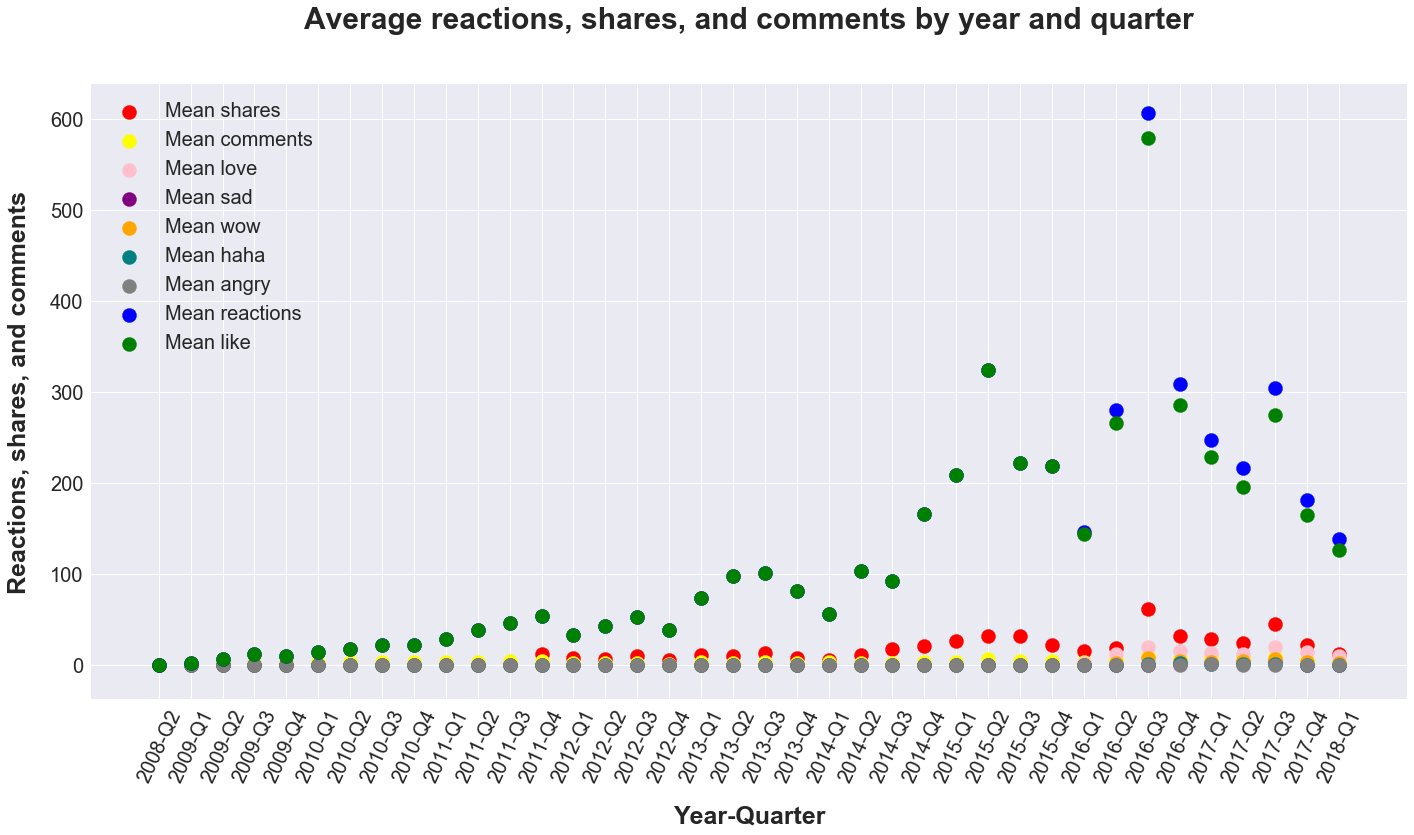

In [19]:

# Generate plots for likes, comments, and shares
plt.scatter(x=g_mean['Year Quarter'], y=g_mean['Mean shares'], s=200, c='red')
plt.scatter(x=g_mean['Year Quarter'], y=g_mean['Mean comments'], s=200, c='yellow')
plt.scatter(x=g_mean['Year Quarter'], y=g_mean['Mean love'], s=200, c='pink')
plt.scatter(x=g_mean['Year Quarter'], y=g_mean['Mean sad'], s=200, c='purple')
plt.scatter(x=g_mean['Year Quarter'], y=g_mean['Mean wow'], s=200, c='orange')
plt.scatter(x=g_mean['Year Quarter'], y=g_mean['Mean haha'], s=200, c='teal')
plt.scatter(x=g_mean['Year Quarter'], y=g_mean['Mean angry'], s=200, c='grey')
plt.scatter(x=g_mean['Year Quarter'], y=g_mean['Mean reactions'], s=200, c='blue')
plt.scatter(x=g_mean['Year Quarter'], y=g_mean['Mean like'], s=200, c='green')


# Format plot figure
plt.title("Average reactions, shares, and comments by year and quarter",
          y = 1.08, fontweight = "bold", fontsize=30)
plt.xlabel("Year-Quarter", labelpad = 20, fontsize=25, fontweight = "bold")
plt.ylabel("Reactions, shares, and comments", labelpad = 20, fontsize=25, fontweight = "bold")
plt.xticks(rotation = 65, fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout(pad = 2)

# Format legend
leg = plt.legend(loc = 'upper left', fontsize = 20)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor('none')

plt.show()

#### 3.1.2 Heatmap of reactions over years and quarters

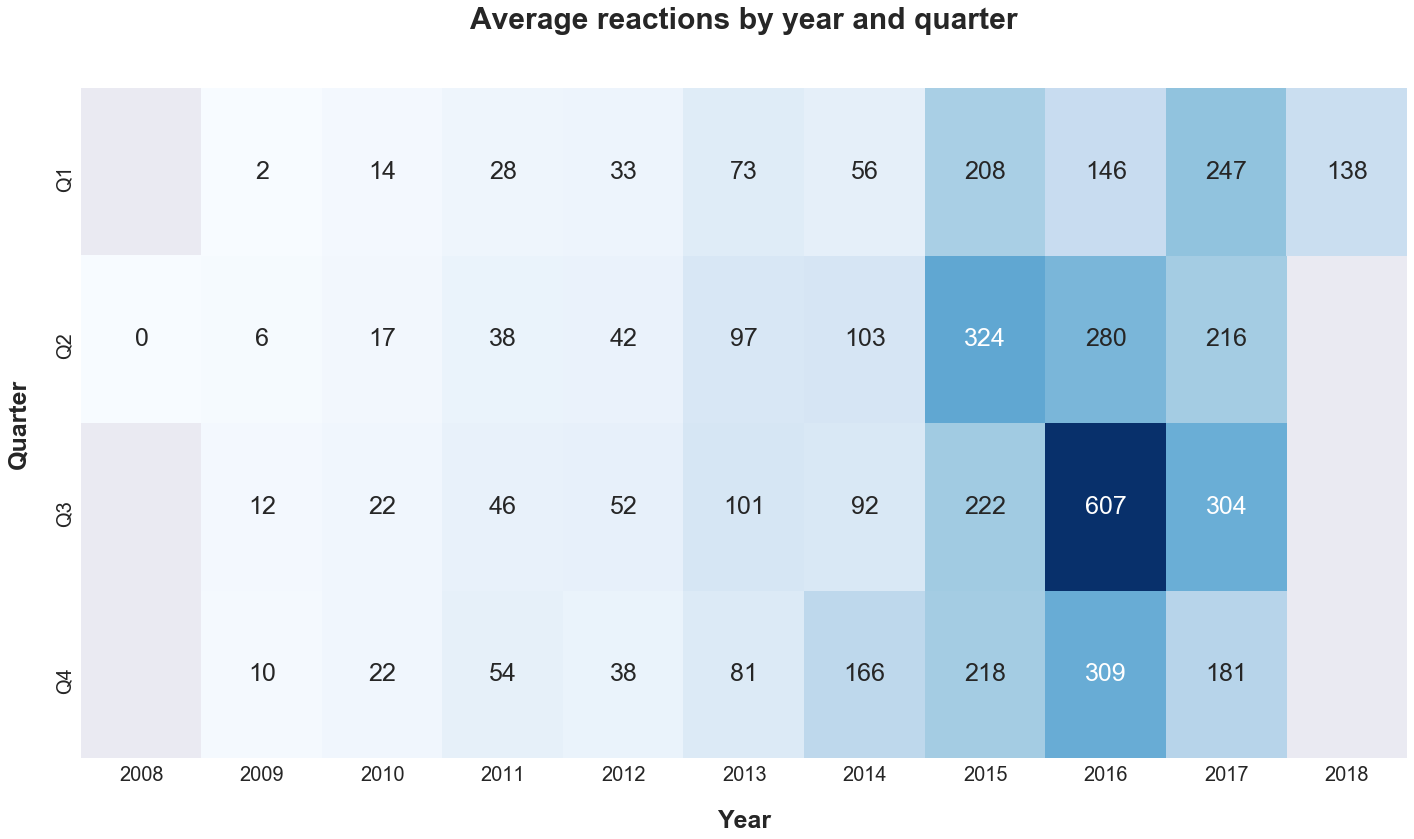

In [20]:
# Pivot data and generate heatmap
g_df_pivot = g_mean.pivot('Quarter', 'Year', 'Mean reactions')
ax = sns.heatmap(g_df_pivot, annot=True, annot_kws={"size": 25},
                 fmt='g', cmap='Blues', cbar=False)

# Format heatmap
plt.title("Average reactions by year and quarter", y = 1.08, fontweight = "bold", fontsize=30)
plt.xlabel("Year", labelpad = 25, fontsize=25, fontweight = "bold")
plt.ylabel("Quarter", labelpad = 25, fontsize=25, fontweight = "bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout(pad = 2)


### 3.2 Visualizing the distribution of reactions


#### 3.2.1 Average reactions by year

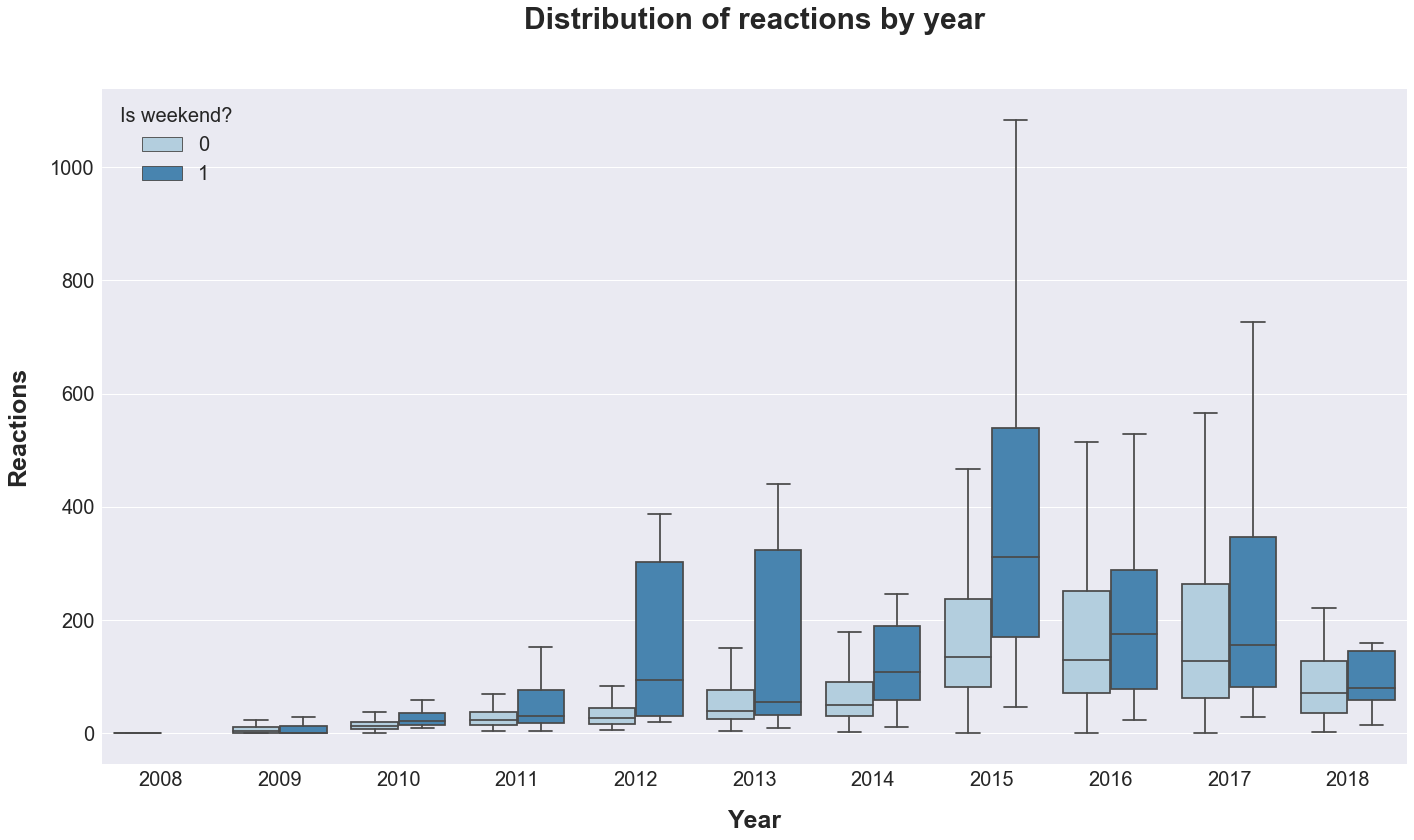

In [21]:
# Create boxplot
ax = sns.boxplot(data = posts5, x='year', y='reactions', showfliers=False,
                 hue='is_weekend', palette="Blues")

# Format figure
plt.title("Distribution of reactions by year", y = 1.08, fontweight = "bold", fontsize=30)
plt.xlabel("Year", labelpad = 20, fontsize=25, fontweight = "bold")
plt.ylabel("Reactions", labelpad = 20, fontsize=25, fontweight = "bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout(pad = 2)

# Format legend
leg = plt.legend(loc = 'upper left', fontsize = 20, title='Is weekend?')
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor('none')
leg.get_title().set_fontsize('20')

plt.show()

#### 3.2.2 Average likes by month

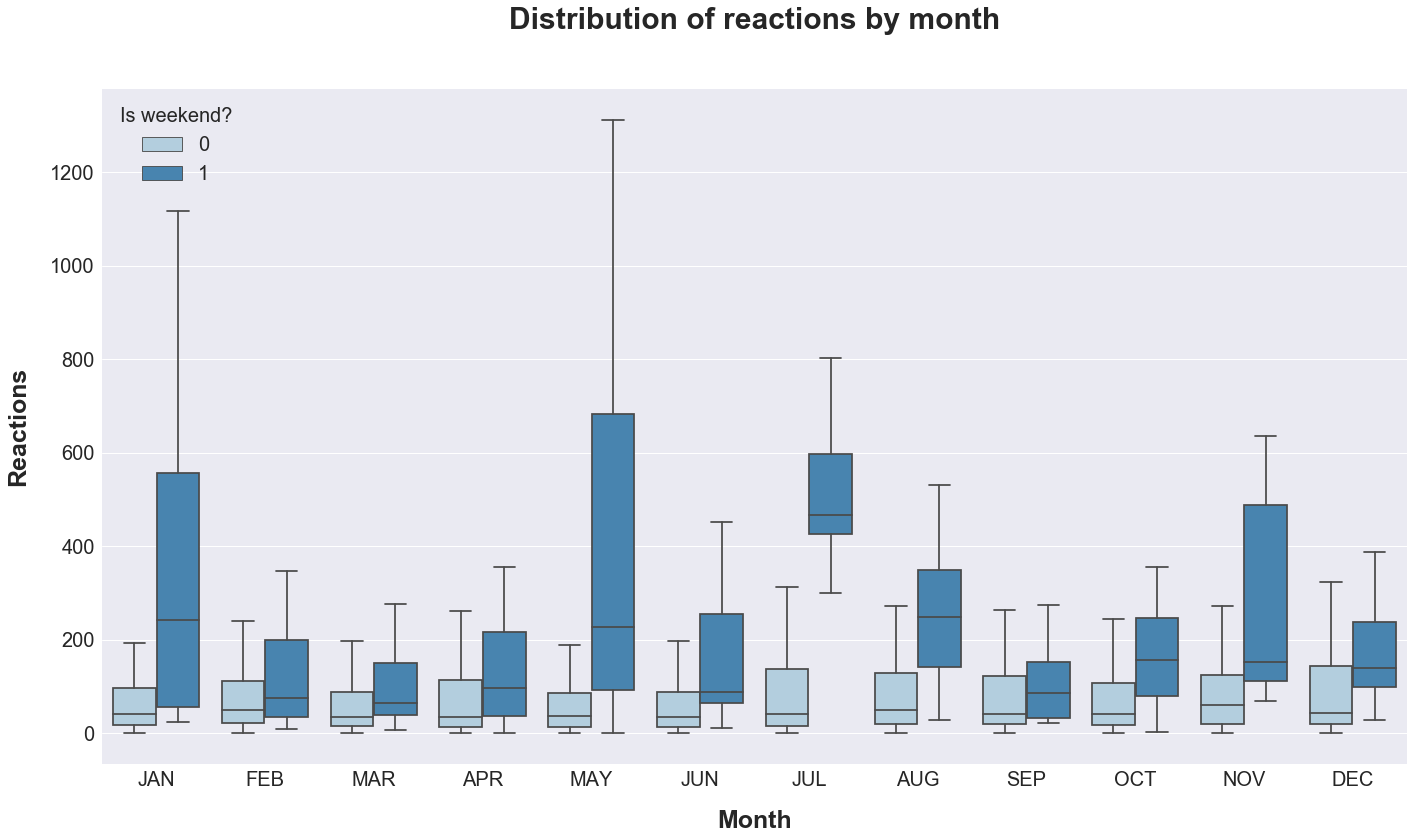

In [22]:
# Create figure
months_order = ['JAN', 'FEB', 'MAR', 'APR',
                'MAY', 'JUN', 'JUL', 'AUG',
                'SEP', 'OCT', 'NOV', 'DEC']
ax = sns.boxplot(data = posts5, x='month', y='reactions', order=months_order,
                 showfliers=False, hue='is_weekend', palette="Blues")

# Format figure
plt.title("Distribution of reactions by month", y = 1.08, fontweight = "bold", fontsize=30)
plt.xlabel("Month", labelpad = 20, fontsize=25, fontweight = "bold")
plt.ylabel("Reactions", labelpad = 20, fontsize=25, fontweight = "bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout(pad = 2)

# Format legend
leg = plt.legend(loc = 'upper left', fontsize = 20, title='Is weekend?')
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_facecolor('none')
leg.get_title().set_fontsize('20')

plt.show()

#### 3.2.3 Average likes by weekday

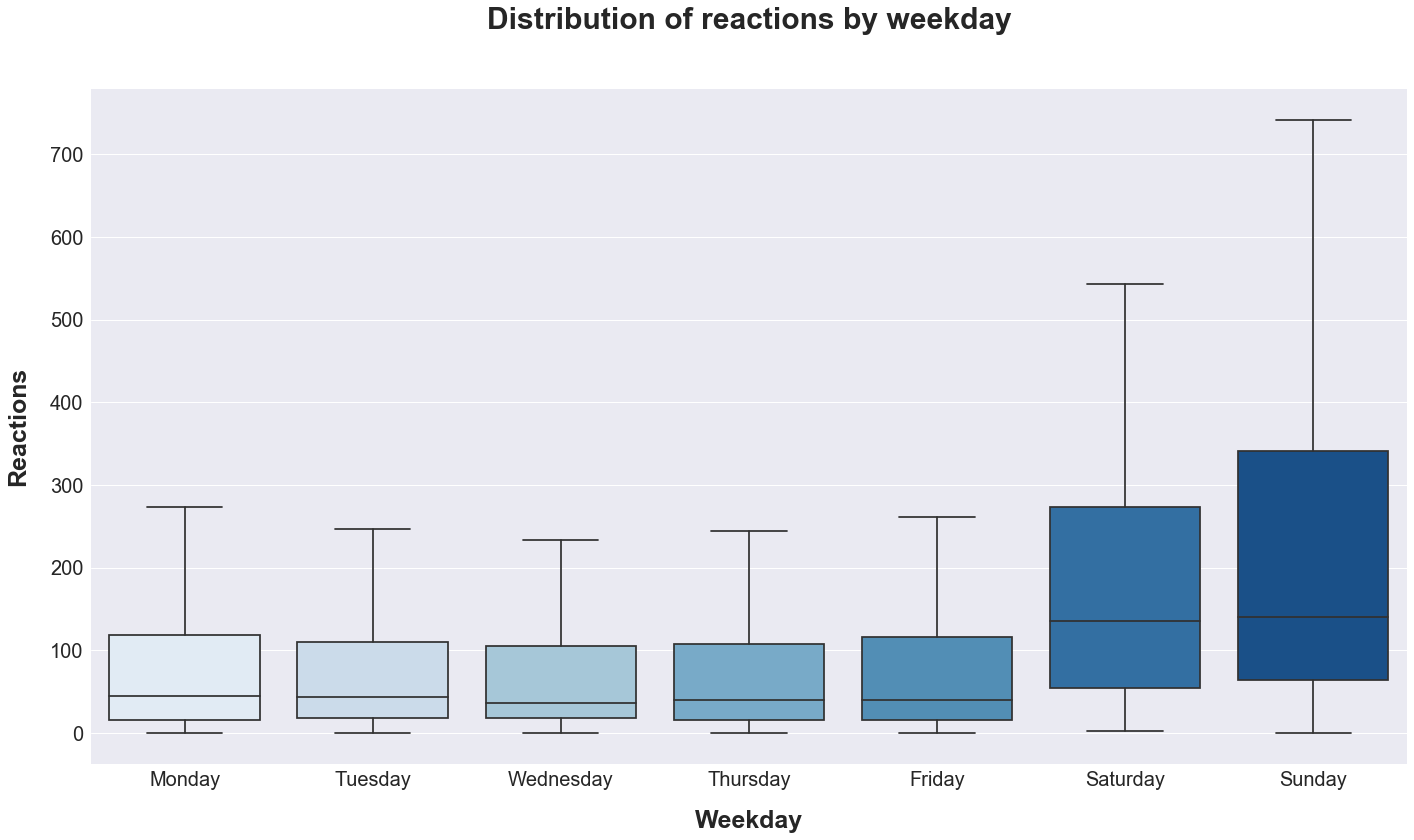

In [23]:
# Create figure
weekdays_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                  'Friday', 'Saturday', 'Sunday']
ax = sns.boxplot(data = posts5, x='weekday', y='reactions', order=weekdays_order,
                 showfliers=False, palette="Blues")

# Format figure
plt.title("Distribution of reactions by weekday", y = 1.08, fontweight = "bold", fontsize=30)
plt.xlabel("Weekday", labelpad = 20, fontsize=25, fontweight = "bold")
plt.ylabel("Reactions", labelpad = 20, fontsize=25, fontweight = "bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout(pad = 2)

plt.show()

#### 3.2.4 Average likes by hour of the day

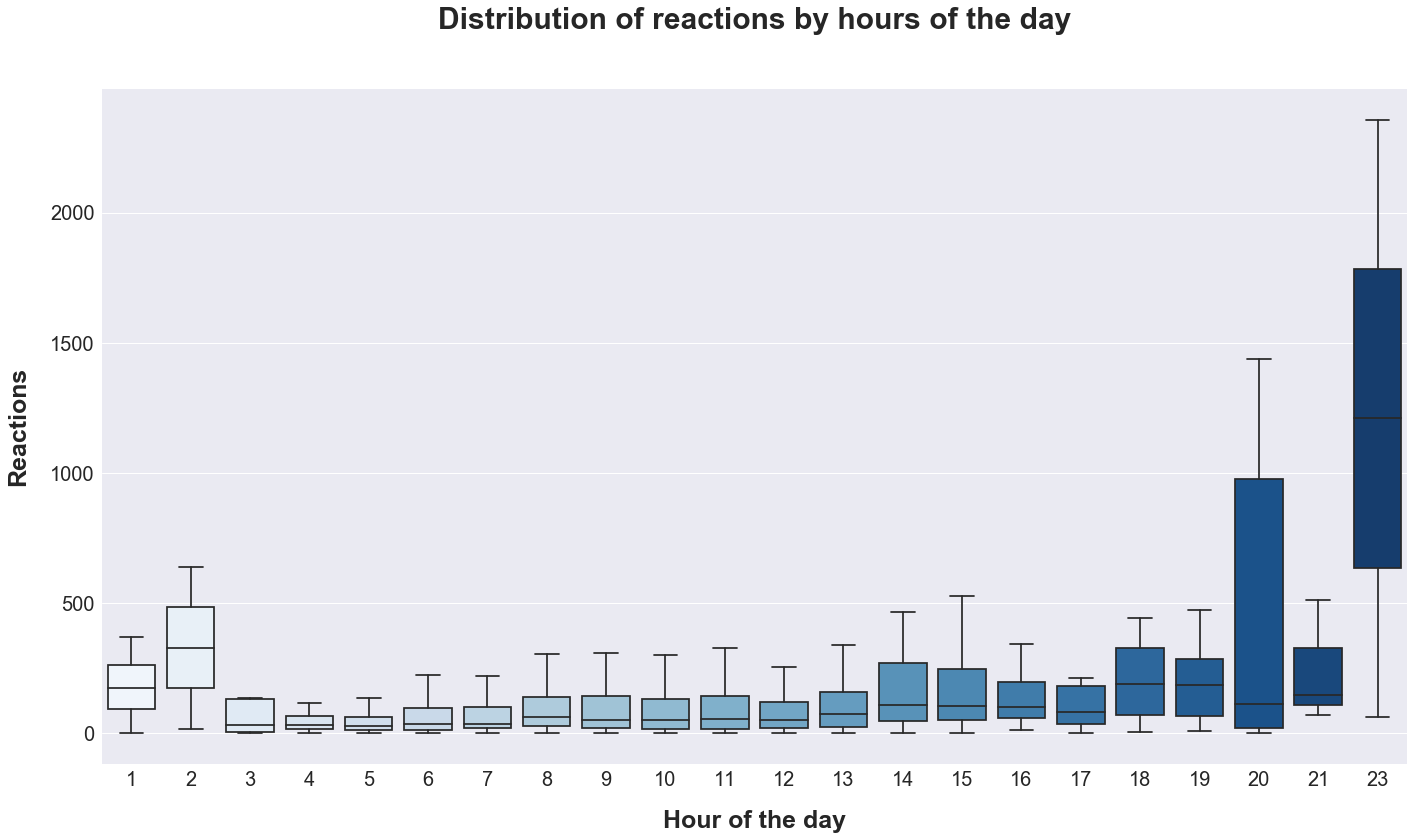

In [24]:
# Create figure
ax = sns.boxplot(data = posts5, x='hour', y='reactions', 
                 showfliers=False, palette='Blues')

# Format figure
plt.title("Distribution of reactions by hours of the day", y = 1.08, fontweight = "bold", fontsize=30)
plt.xlabel("Hour of the day", labelpad = 20, fontsize=25, fontweight = "bold")
plt.ylabel("Reactions", labelpad = 20, fontsize=25, fontweight = "bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout(pad = 2)

plt.show()

## 4. Data modeling

This section presents a toy example showing how the processed data can be used for data modeling purposes. The example is far from exhaustive given the limited scope of the tutorial. However, the example is useful to complete the data science pipeline of the tutorial. The example uses a logistic regression to classify posts with high reactions (over 75th percentile of reactions distribution) or low reactions (below 75th percentile of reactions distribution). The 75th percentile was chosen subjectively with the only purpose of having a cutoff to predict a binary outcome. 


### 4.1 Generate labels


In [25]:
def generate_labels(dataframe):
    """DESCRIPTION: create label for each post indicating whether the reactions
                    received by  each post were above or below the 75% percentile
                    of the total distribution of reactions
       PARAMETER(S): Facebook dataframe
       RETURNS: datagrame with label column"""
    # Get copy of dataframe
    data = dataframe.copy(deep=True) 
    # Get cutoff for high reactions (over 75% percentile) and low (below 75% percentile)
    cutoff_high = data['reactions'].quantile(.4)
    # Create column with labels
    data['label'] = data['reactions'].apply(lambda x: 0 if x < cutoff_high else 1)
    return data

posts6 = generate_labels(posts5)
posts6.head()

,datetime,message,name,status_type,type,link,reactions,like,angry,haha,...,cos_weekday,sin_hour,cos_hour,elap_min,sin_elap_min,cos_elap_min,has_link,is_weekend,is_graduation,label
0,2018-03-28 04:56:05,today carnegie mellon thank donor day student ...,Thank a Donor - Engage with CMU - Carnegie Mel...,shared_story,link,https://www.cmu.edu/engage/give/donor-recognit...,40,38,0,0,...,-0.222521,0.866025,5.000000e-01,296,0.961262,2.756374e-01,1,0,0,1
1,2018-03-27 07:55:32,officially spring official say done flu season...,Flu Forecasting,added_video,video,https://www.facebook.com/carnegiemellonu/video...,21,21,0,0,...,0.623490,0.965926,-2.588190e-01,475,0.876727,-4.809888e-01,1,0,0,0
2,2018-03-26 08:25:26,saturday march 24 carnegie mellon greek sing r...,Greek Sing 2018,added_photos,photo,https://www.facebook.com/carnegiemellonu/photo...,83,76,0,0,...,1.000000,0.866025,-5.000000e-01,505,0.806445,-5.913096e-01,1,0,0,1
3,2018-03-22 10:35:02,graduating may today 7 p attend grad fair prep...,Cap and Gown Information - Commencement Weeken...,shared_story,link,https://www.cmu.edu/commencement/graduates/cap...,51,50,0,0,...,-0.900969,0.500000,-8.660254e-01,635,0.362438,-9.320079e-01,1,0,0,1
4,2018-03-22 06:00:32,14th annual competition went qatar academy doh...,Qatar Academy Wins CMU-Q's Botball - News - Ca...,shared_story,link,https://www.cmu.edu/news/stories/archives/2018...,23,23,0,0,...,-0.900969,1.000000,6.123234e-17,360,1.000000,6.123234e-17,1,0,0,0


### 4.2 Split data into train, validation, and test

The following function returns training, validation, and test sets. Since this is a toy example that does not tune any hyperparameters or compare models' classification errors, we only use the train and test sets. Despite not using the validation set, the function returns it in case the reader is interested in using it.


In [26]:
def get_train_validation_test(dataframe):
    """DESCRIPTION: splits data into train, validation, and test
       PARAMETER(S): dataframe: dataframe with Facebook data
       RETURNS: 3 dataframes: train, validation, and test"""
    # Get copy of dataframe
    data = dataframe.copy(deep=True)   

    # Split data into train and test data
    np.random.seed(0)
    msk1 = np.random.rand(len(data)) < 0.7
    train_to_split = data[msk1]
    test = data[~msk1]

    # Split train data into train and validation sets
    msk2 = np.random.rand(len(train_to_split)) < 0.8
    train = train_to_split[msk2]
    val = train_to_split[~msk2]

    return (train, val, test)

(train, val, test) = get_train_validation_test(posts6)


### 4.3 Fit model and classify

The following code chunk utilizes a [TFIDF](https://lizrush.gitbooks.io/algorithms-for-webdevs-ebook/content/chapters/tf-idf.html) vectorizer and a logistic regression model to classify posts as high reactions or low reactions. The TFIDF allows us to penalize the words that appear in numerous posts. In the case of CMU's Facebook Page, words like 'CMU', 'Carnegie', and 'University' are penalized because they appear in several posts. 


In [27]:
# Get TFIDF vectorizer
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()    

# Get predictors and response from both the train and test datasets
X_train = tfidf_vectorizer.fit_transform(train['message'])
y_train = train['label']
X_test = tfidf_vectorizer.transform(test['message'])
y_test = test['label']

# Fit logistic regression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

# Predict and get accuracy
y_predicted = logistic.predict(X_test)
y_proba = logistic.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, y_predicted)
accuracy



0.7192982456140351

## 5. Next steps

<ul> 
<li> 
The code is limited by the fact that the maximum number of posts returned by the Facebook Graph API is 600 per year. It would be worthy to explore the possibility of writing a scrapper that extract all posts from a given Facebook Page.  
</li>
<li>
The tutorial generates features to build a more robust model with cross-validation for model selection and hyperparameters. 
</li>
<li>
The reader should consider building a model that uses a continuous feature as response, such as the <i><b>reactions</b></i> variable.
</li>
<li>
Since the tutorial already processes the <i><b>message</b></i> variable, the reader can conduct further text analysis, such as [sentiment analysis](https://www.analyticsvidhya.com/blog/2017/01/sentiment-analysis-of-twitter-posts-on-chennai-floods-using-python/) or [n-grams](https://appliedmachinelearning.wordpress.com/2017/04/30/language-identification-from-texts-using-bi-gram-model-pythonnltk/).
</ul> 
